# Modelo con mutiples salidas

En este notebook, crearemos un modelo con multiples salidas usando el API funcional de keras.

Para el modelo usaremos lo datos de [Energy efficiency](https://archive.ics.uci.edu/dataset/242/energy+efficiency)

## Importar modulos

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import requests
from io import BytesIO
import zipfile

## Preparar los datos

Descargamos el dataset y preparamos nuestros datos de entrenamiento y pruebas

In [2]:
# download file
url = 'https://archive.ics.uci.edu/static/public/242/energy+efficiency.zip'
r = requests.get(url)
zip_data = BytesIO(r.content)

# unzip
with zipfile.ZipFile(zip_data, 'r') as zip_file:
    with zip_file.open('ENB2012_data.xlsx') as excel_file:
        df = pd.read_excel(excel_file)

# random sort
df = df.sample(frac=1)

df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
470,0.66,759.5,318.5,220.5,3.5,4,0.25,4,12.86,16.17
379,0.64,784.0,343.0,220.5,3.5,5,0.25,2,17.11,20.43
31,0.71,710.5,269.5,220.5,3.5,5,0.00,0,6.40,11.67
747,0.74,686.0,245.0,220.5,3.5,5,0.40,5,14.39,16.70
737,0.79,637.0,343.0,147.0,7.0,3,0.40,5,41.96,37.70


In [3]:
# split data
train, test = train_test_split(df, test_size=0.2)

def format_data(df: pd.DataFrame):
    y1 = df['Y1'].values
    y2 = df['Y2'].values
    X = df.drop(['Y1', 'Y2'], axis=1)
    return X, (y1, y2)

X_train, Y_train = format_data(train)
X_test, Y_test = format_data(test)

In [4]:
# normalize data
scaler = preprocessing.StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

## El modelo

Ahora construiremos nuestro modelo teniendo en cuenta que va a tener dos salidas

In [5]:
def build_model():
    input_layer = tf.keras.layers.Input(shape=(8,))
    hidden_layer = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    hidden_layer = tf.keras.layers.Dense(128, activation='relu')(hidden_layer)

    # ouput 1
    y1 = tf.keras.layers.Dense(1, name='y1')(hidden_layer)

    # output 2
    hidden_layer = tf.keras.layers.Dense(64, activation='relu')(hidden_layer)

    y2 = tf.keras.layers.Dense(1, name='y2')(hidden_layer)

    return tf.keras.models.Model(inputs=input_layer, outputs=[y1, y2])


## Graficar nuestro modelo

Vamos a graficar nuestro modelo donde podemos observar de forma mas simple nuestras dos salidas `y1` y `y2`, tambien podemos ver que `y2` tiene una capa extra, esta es la de `tf.keras.layers.Dense(units=1, name='y2', activation='linear')(X)`

In [6]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          1152        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 64)           8256        ['dense_1[0][0]']                
                                                                                              

## Configurar parametros

In [7]:
model.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    loss={
        'y1': tf.keras.losses.MeanSquaredError(),
        'y2': tf.keras.losses.MeanSquaredError(),
    },
    metrics={
        'y1': tf.keras.metrics.RootMeanSquaredError(),
        'y2': tf.keras.metrics.RootMeanSquaredError(),
    }
)

# Entrenar el modelo

In [8]:
model.fit(
    X_train_norm, Y_train,
    epochs=500, batch_size=10,
    validation_data=(X_test_norm, Y_test),
    verbose=0
)

## Evaluar el modelo

Ahora vamos a evaluar el modelo y graficar los datos para tener una mejor idea de lo que esta pasando

In [9]:
model.evaluate(X_test_norm, Y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.9150 - y1_loss: 0.2067 - y2_loss: 0.7082 - y1_root_mean_squared_error: 0.4547 - y2_root_mean_squared_error: 0.8416


[0.9149883389472961,
 0.2067471146583557,
 0.7082412838935852,
 0.454694539308548,
 0.8415707349777222]

## Comparar datos reales y predichos

In [10]:
pred = model.predict(X_test_norm)
print(pred[0][:5])
Y_test[0][:5]

5/5 [==============================] - 0s 1ms/step
[[33.359097]
 [37.002422]
 [23.915794]
 [35.689697]
 [24.020735]]


array([33.16, 37.26, 24.03, 35.94, 24.24])

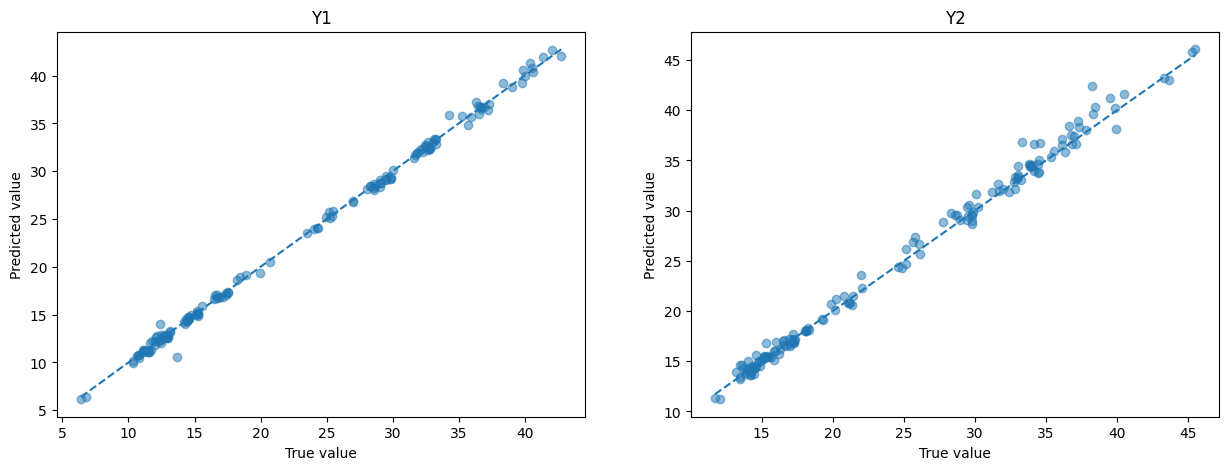

In [11]:
def plot_values(ax, y_true, y_pred, title):
    ax.scatter(y_true, y_pred, alpha=0.5)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--')
    ax.set_xlabel('True value')
    ax.set_ylabel('Predicted value')
    ax.set_title(title)

# Y1 vs pred
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_values(ax[0], Y_test[0], pred[0], 'Y1')
plot_values(ax[1], Y_test[1], pred[1], 'Y2')